Final Project Part 1 : Copy Tutorial & Markdown
Additional to Markdown there will be Comments on Code

In [1]:
# Importing all necessary libraries
import numpy as np
import sep
from astropy.io import fits
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import rcParams
from matplotlib.patches import Ellipse

Sets up system to read test image and display plots, specifically setting size parameters and functionality for the plots to be saved directly into jupyter notebook.

In [2]:
# additional setup for reading the test image and displaying plots
# Lets the plots be saved into jupyter notebook
%matplotlib inline
rcParams['figure.figsize'] = [10., 8.] # Set up Figure Size

Read image into standard 2-d numpy array and show image, by first defining the name of the file then unpacking the file data. Then printing the plotting the Fits data as is to see what the starting image is to adjust later.

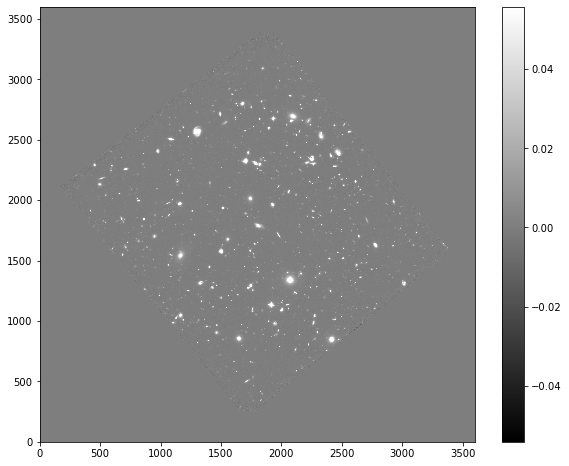

In [3]:
# read image into standard 2-d numpy array and show image

#define file names
fdata_image = "hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits"
#read in data
full_data = fits.open(fdata_image)
#get image data
data = full_data[0].data
data = data.byteswap().newbyteorder() # Input array with dtype '>f4' has non-native byte order, this fixes it
# show the image
m, s = np.mean(data), np.std(data) # Gets  mean and standard deviation of image to set up plot
plt.imshow(data, interpolation='nearest', cmap='gray',
                vmin=m-s, vmax=m+s, origin='lower') # Plots image with Settings
plt.colorbar(); #Color bar on side
plt.savefig("hubble_default_data.png")

Begin the process to subtract the background. We have to estimate the background then detect the sources. Obtaining the Background object, that holds information on the spatially varying background and noise level, lets us do a lot more things. We can get the mean and noise of the image background. Setting the background as a 2-d array like the original image lets us plot a similar plot to compare.

0.0
0.0005398219218477607


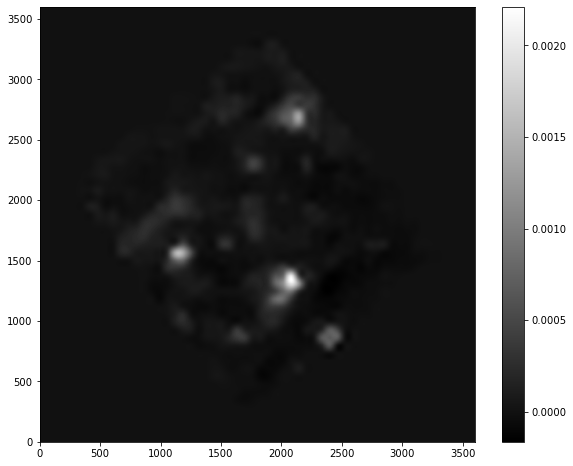

In [4]:
# Background Subtraction

# measure a spatially varying background on the image
bkg = sep.Background(data)

# get a "global" mean and noise of the image background:
print(bkg.globalback)
print(bkg.globalrms)

# evaluate background as 2-d array, same size as original image
bkg_image = bkg.back()
# bkg_image = np.array(bkg) # equivalent to above

# show the background
plt.imshow(bkg_image, interpolation='nearest',
                cmap='gray', origin='lower') # Plots image with Settings
plt.colorbar(); #Color Bar on Side
plt.savefig("hubble_background_data.png")

Now we do the same with the background noise and set it as a 2-d array like the original image lets us plot a similar plot to compare. In the end though to subtract the background, its as simple as taking the data and subtracting the Background Object from earlier.

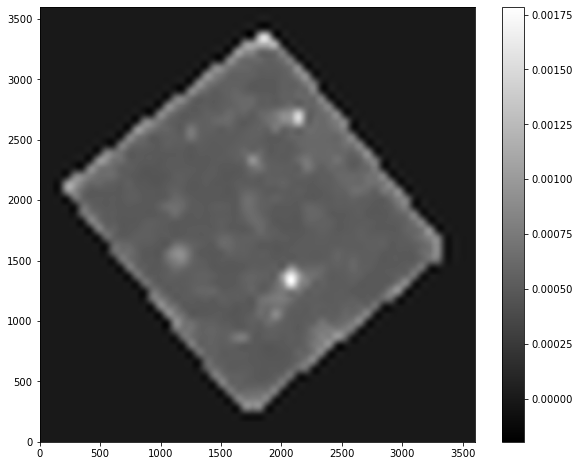

In [5]:
# evaluate the background noise as 2-d array, same size as original image
bkg_rms = bkg.rms()

# show the background noise
plt.imshow(bkg_rms, interpolation='nearest',
                cmap='gray', origin='lower') # Plots image with Settings
plt.colorbar(); #Color Bar on Side

# subtract the background
data_sub = data - bkg
plt.savefig("hubble_background_noise_data.png")

Using the subtracted background data, we can run object detection on the plot. The background noise level is pretty flat, seen from the graph just above going from 0 to .00175. So here we're setting the detection threshold to be a constant value of 1.5σ where σ is the global background RMS. Now we can plot the fits image with the detected object 'scan' on top.

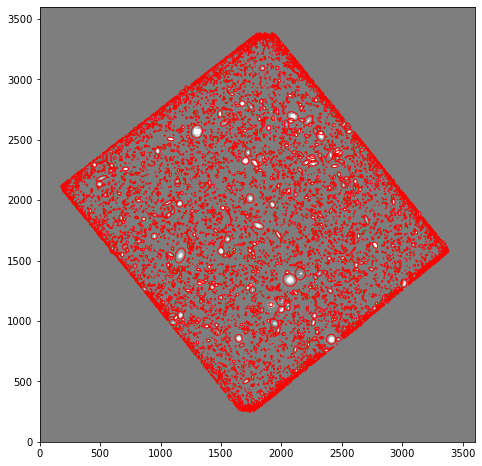

In [6]:
# Object Detection
objects = sep.extract(data_sub, 1.5, err=bkg.globalrms) # extract the objects using noise and subbed data

# how many objects were detected
len(objects)

# plot background-subtracted image
fig, ax = plt.subplots()
m, s = np.mean(data_sub), np.std(data_sub) # Gets  mean and standard deviation of image to set up plot
im = ax.imshow(data_sub, interpolation='nearest', cmap='gray',
                vmin=m-s, vmax=m+s, origin='lower') # Plots image with Settings

# plot an ellipse for each object
for i in range(len(objects)): # For each object
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]), #objects['x'] and objects['y'] are centroid coordinates 
                width=6*objects['a'][i],
                height=6*objects['b'][i],
                angle=objects['theta'][i] * 180. / np.pi) # Set up ellipse around detected object
    e.set_facecolor('none') # empty circle
    e.set_edgecolor('red') # outline circle red
    ax.add_artist(e) # add circles

plt.savefig("hubble_detected_data.png")

In [7]:
sources = len(objects)
print("Number of sources: ", sources)

Number of sources:  8640


Below shows Available fields giving information such as second moments, peak pixel positions, values, etc

In [8]:
# available fields
objects.dtype.names

('thresh',
 'npix',
 'tnpix',
 'xmin',
 'xmax',
 'ymin',
 'ymax',
 'x',
 'y',
 'x2',
 'y2',
 'xy',
 'errx2',
 'erry2',
 'errxy',
 'a',
 'b',
 'theta',
 'cxx',
 'cyy',
 'cxy',
 'cflux',
 'flux',
 'cpeak',
 'peak',
 'xcpeak',
 'ycpeak',
 'xpeak',
 'ypeak',
 'flag')

We'll find the circular aperture photometry, the circular measurement of light which falls inside a particular aperture, with a 3 pixel radius at the locations of the objects

In [9]:
# Aperture Photometry
flux, fluxerr, flag = sep.sum_circle(data_sub, objects['x'],
                objects['y'], 3.0, err=bkg.globalrms, gain=1.0) # Get the light data for each object detected
filtered = []

for i in range(8640):
    # for object print flux and flux error
    if (flux[i]<1 and flux[i]>-.25 ): #arbitrary numbers picked based on mean, median and std for nicer histogram
        filtered.append(flux[i])

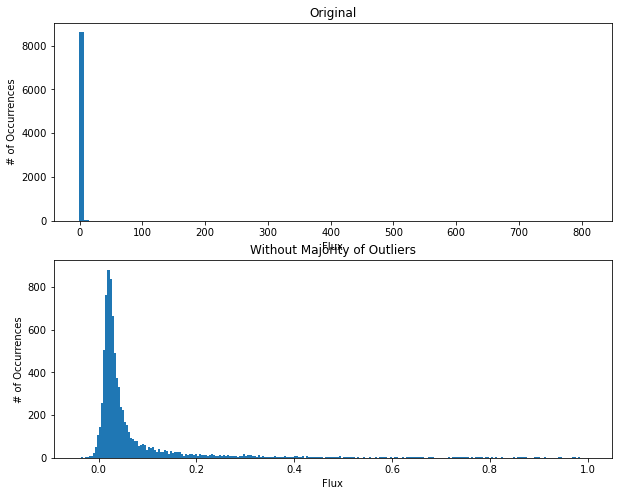

In [10]:
# Histogram their fluxes
fig, (ax1, ax2) = plt.subplots(nrows=2)

ax1.hist(flux, bins = 100)
ax1.set_title('Original')
ax1.set_xlabel("Flux")
ax1.set_ylabel("# of Occurrences")

ax2.hist(filtered, bins = 250)
ax2.set_title('Without Majority of Outliers')
ax2.set_xlabel("Flux")
ax2.set_ylabel("# of Occurrences")

plt.savefig("histogram_of_flux.pdf") # save the figure as a PDF
plt.show()

In [11]:
# Statistics of Flux
flux_mean = np.mean(flux)
flux_median = np.median(flux)
flux_std = np.std(flux)
print("Mean of Flux:", flux_mean)
print("Median of Flux:", flux_median)
print("Standard Deivation of Flux:", flux_std)

Mean of Flux: 0.36186200071901703
Median of Flux: 0.030956558069156016
Standard Deivation of Flux: 9.243527842776762


In [12]:
flux_max = np.max(flux)
print("On the far right of the graph the Largest Outlier Flux:", flux_max)
print("Number of Standard Deviations Away from mean:", (flux_max-flux_mean)/flux_std)

On the far right of the graph the Largest Outlier Flux: 807.2972835731507
Number of Standard Deviations Away from mean: 87.29734310293674


In [13]:
# COLORS

# read image into standard 2-d numpy array and show image
#define file names
fdata_image_1 = "hlsp_hudf12_hst_wfc3ir_udfmain_f125w_v1.0_drz.fits"
fdata_image_2 = "hlsp_hudf12_hst_wfc3ir_udfmain_f160w_v1.0_drz.fits"

#read in data
full_data_1 = fits.open(fdata_image_1)
full_data_2 = fits.open(fdata_image_1)

#get image data
data_1 = full_data_1[0].data
data_1 = data_1.byteswap().newbyteorder() # Input array with dtype '>f4' has non-native byte order, this fixes it
data_2 = full_data_1[0].data
data_2 = data_2.byteswap().newbyteorder() # Input array with dtype '>f4' has non-native byte order, this fixes it

In [14]:
min_0 = data.min()
max_0 = data.max()
min_1 = data_1.min()
max_1 = data_1.max()
min_2 = data_2.min()
max_2 = data_2.max()

r = (data-min_0) / (max_0-min_0)
g = (data_1-min_1) / (max_1-min_1)
b = (data_2-min_2) / (max_2-min_2)

rgb_image = np.zeros((3600, 3600, 3))
rgb_image[:,:,0]=b
rgb_image[:,:,1]=g
rgb_image[:,:,2]=r

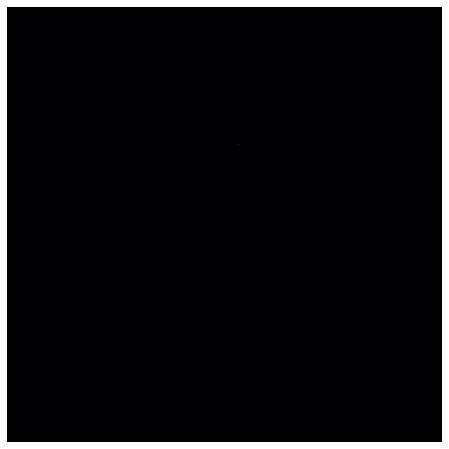

In [15]:
f, ax = plt.subplots(1, 1)
ax.axis('off')
plt.imshow(rgb_image)
plt.savefig("3_color_false_image.png")